# Custom Real-time Plots in Deep Learning
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---

## What do we mean by real-time plots?

Training a complex deep learning model with a large dataset can be time-consuming. As the epochs go by, reams of numbers flash on your screen. Your eyes (and the brain) get tired. 

Where is that exciting accuracy plot constantly updating you about the progress? How do you know if the model is learning something useful? And, just how fast?

A real-time visual update would be pretty great, won't it?

Let's see how to do that with Keras/TensorFlow...

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pandas as pd
mpl.rcParams['figure.dpi']=100

## Functions for building, compiling, and training models

In [2]:
def build_classification_model(
    num_layers=1,
    architecture=[32],
    act_func="relu",
    input_shape=(28, 28),
    dropout = 0.1,
    output_bias = None,
    output_class=10):
    """
  Builds a densely connected neural network model from user input
  
  Arguments
          num_layers: Number of hidden layers
          architecture: Architecture of the hidden layers (densely connected)
          act_func: Activation function. Could be 'relu', 'sigmoid', or 'tanh'.
          input_shape: Dimension of the input vector
          output_class: Number of classes in the output vector
  Returns
          A neural net (Keras) model for classification
    """
    layers = [tf.keras.layers.Flatten(input_shape=input_shape)]
    if act_func == "relu":
        activation = tf.nn.relu
    elif act_func == "sigmoid":
        activation = tf.nn.sigmoid
    elif act_func == "tanh":
        activation = tf.nn.tanh

    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    for i in range(num_layers):
        layers.append(tf.keras.layers.Dense(architecture[i], activation=tf.nn.relu))
        layers.append(tf.keras.layers.Dropout(dropout))
    layers.append(tf.keras.layers.Dense(output_class, activation=tf.nn.sigmoid))

    model = tf.keras.models.Sequential(layers)
    return model

In [3]:
def compile_train_model(
    model,
    x_train,
    y_train,
    callbacks=None,
    learning_rate=0.001,
    metrics = None,
    class_weight = None,
    batch_size=1,
    epochs=10,
    verbose=0,
):
    """
  Compiles and trains a given Keras model with the given data. 
  Assumes Adam optimizer for this implementation.
  Assumes categorical cross-entropy loss.
  
  Arguments
          learning_rate: Learning rate for the optimizer Adam
          batch_size: Batch size for the mini-batch optimization
          epochs: Number of epochs to train
          verbose: Verbosity of the training process
  
  Returns
  A copy of the model
  """

    model_copy = model
    model_copy.compile(
        optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )

    if callbacks != None:
        model_copy.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weight,
            verbose=verbose,
        )
    else:
        model_copy.fit(
            x_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size,
            class_weight=class_weight,
            verbose=verbose
        )
    return model_copy

## Custom callback class for plotting real-time updates

In [4]:
class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and metrics
        self.losses = []
        self.acc = []
        self.f1score = []
        self.precision = []
        self.recall = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        """
        Calculates and plots Precision, Recall, F1 score
        """
        # Extract from the log
        tp = logs.get('tp')
        fp = logs.get('fp')
        fn = logs.get('fn')
        loss = logs.get('loss')
        
        m = self.model
        preds = m.predict(X_train)
        
        # Calculate
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1score = 2*(precision*recall)/(precision+recall)    
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(loss)
        self.f1score.append(f1score)
        self.precision.append(precision)
        self.recall.append(recall)
        
        # Plots every 5th epoch
        if epoch > 0 and epoch%5==0:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(10,3))
            plt.title("Distribution of prediction probabilities at epoch no. {}".format(epoch), 
                      fontsize=16)
            plt.hist(preds, bins=50,edgecolor='k')
            
            plt.figure(figsize=(10,3))
            plt.title("Loss over epoch")
            plt.plot(N, self.losses)
            fig, ax = plt.subplots(1,3, figsize=(12,4))
            ax = ax.ravel()
            ax[0].plot(N, self.precision, label = "Precision", c='red')
            ax[1].plot(N, self.recall, label = "Recall", c='red')
            ax[2].plot(N, self.f1score, label = "F1 score", c='red')
            ax[0].set_title("Precision at Epoch No. {}".format(epoch))
            ax[1].set_title("Recall at Epoch No. {}".format(epoch))
            ax[2].set_title("F1-score at Epoch No. {}".format(epoch))
            ax[0].set_xlabel("Epoch #")
            ax[1].set_xlabel("Epoch #")
            ax[2].set_xlabel("Epoch #")
            ax[0].set_ylabel("Precision")
            ax[1].set_ylabel("Recall")
            ax[2].set_ylabel("F1 score")
            ax[0].set_ylim(0,1)
            ax[1].set_ylim(0,1)
            ax[2].set_ylim(0,1)
            
            plt.show()

## A synthetic and imbalanced dataset

In [5]:
n_features = 15
n_informative = n_features

In [6]:
d = make_classification(n_samples=10000,
                        n_features=n_features,
                        n_informative=n_informative,
                        n_redundant=0,
                        n_classes=2,
                        weights=[0.9,0.1],
                        flip_y=0.05,
                        class_sep=0.7)

In [7]:
features, target = d

In [8]:
df = pd.DataFrame(features, columns=['X'+str(i) for i in range(1,16)])
df['targets'] = target

In [9]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,targets
0,-0.016009,1.428689,-0.866501,-0.538710,4.608595,7.130322,-4.506765,-1.192638,-2.476860,3.624462,1.721418,2.732418,-4.275435,0.924629,-2.384918,0
1,-1.352115,-2.852844,-0.322934,-5.167208,2.686828,-1.274492,3.712095,1.381147,1.687931,-0.775942,-0.594912,-0.209636,1.356717,-3.601200,1.100609,1
2,1.179023,1.581427,-3.393464,-3.048254,0.587266,4.160375,-2.850716,2.199855,0.601646,-0.327941,-0.054750,-1.462805,-2.943693,-0.840578,-0.483900,0
3,1.592217,2.311026,-2.766355,-0.409640,-0.552035,1.154037,-3.003885,-4.195423,0.200162,-2.227777,-0.475218,-1.869647,-0.480999,0.894760,-4.065611,1
4,-1.590351,1.494287,-0.644598,2.353262,-5.320925,-1.890232,1.440190,1.191736,1.835463,5.031498,3.373927,1.072960,2.462784,7.361583,-0.031402,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.393561,-0.900824,3.589416,2.875054,-3.798442,-0.777301,-0.800502,-2.119976,2.330223,2.246599,1.214860,1.871206,-1.099120,5.413484,1.985517,0
9996,-5.312948,-1.505171,-1.938539,0.420835,-1.600950,-1.501905,-0.488192,-0.662069,1.693915,-5.705610,-4.701872,-3.416640,0.501388,1.559869,0.712984,0
9997,-0.449172,2.891957,-0.080511,0.855889,-0.318454,0.252323,-3.234492,1.499957,0.122375,0.836722,0.373926,2.379538,-3.507185,1.887642,-0.758404,0
9998,-2.360667,-1.637394,-1.317338,0.701317,-4.051106,-3.542920,2.663398,-0.913114,5.032266,-0.349163,-2.107770,-1.196153,0.740155,-2.044315,3.026633,0


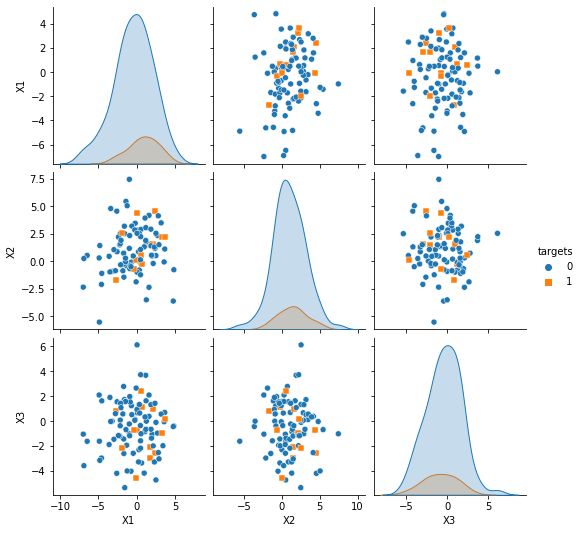

In [10]:
g=sns.pairplot(df.sample(100),vars=["X1","X2","X3"],
               hue="targets",markers=["o", "s"],
               diag_kind="kde",diag_kws=dict(shade=True))

## Training and testing sets and pre-processing

In [11]:
neg, pos = np.bincount(target)

In [12]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.01632046])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.8, random_state=42)

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Metrics and (unequal) weights
We are using unequal weights to improve model prediction for the imbalanced dataset.

In [15]:
input_shape=(X_train.shape[1],)

In [16]:
metrics = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
]

In [17]:
counts = np.bincount(y_train)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

class_weight = {0: weight_for_0, 1: weight_for_1}

In [18]:
plot_metrics = TrainingPlot()

## Model definition and training

In [19]:
m = build_classification_model(num_layers=2,
                               architecture=[64,64],
                               input_shape=input_shape,
                               output_bias= initial_bias,
                               output_class=1)

In [20]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1024      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
______________________________________________________

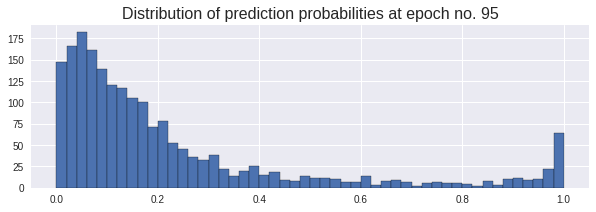

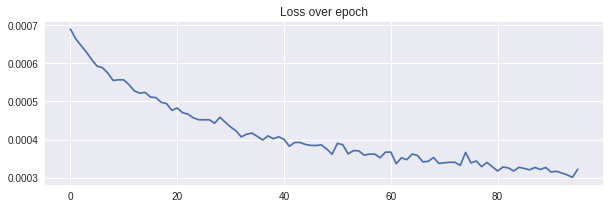

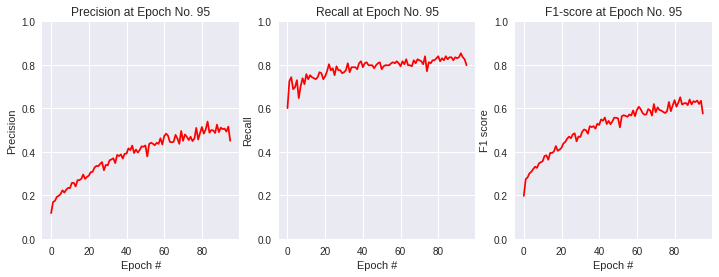

In [21]:
m = compile_train_model(model=m, 
                        x_train=X_train, 
                        y_train=y_train, 
                        metrics=metrics,
                        class_weight=class_weight,
                        callbacks = [plot_metrics],
                        batch_size=32,
                        learning_rate=1e-3,
                        epochs=100,
                        verbose=0)